<a href="https://colab.research.google.com/github/quanmtran/Coursera-Capstone-Project/blob/main/Coursera_Capstone_Project_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
import folium
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# **1. Data collecting and wrangling**

## **1.1. Getting suburbs and coordinates**

First of all, we need geographical data of suburbs in Melbourne, Victoria.
We have scraped names, postcodes and coordinates from this [web page](https://www.geonames.org/postal-codes/AU/VIC/victoria.html). We will only select suburbs in Melbourne's metropolitan area (Postcode from 3000 to 3207).

In [ ]:
# Scrape the table from the web page
url = 'https://www.geonames.org/postal-codes/AU/VIC/victoria.html'
html_content = requests.get(url).text
soup = BeautifulSoup(html_content, 'lxml')
table = soup.find_all('table')

# Store the table in a dataframe
df_table = pd.read_html(str(table))[2]

# Wrangling
df = df_table.loc[df_table['Unnamed: 0'].notna(), :].reset_index(drop=True)
coordinates = df_table.loc[df_table['Unnamed: 0'].isna(), 'Place'].dropna().reset_index(drop=True).str.split('/', expand=True).astype('float32')
df[['Latitude', 'Longitude']] = coordinates

# Select suburbs in Melbourne's metropolitan area (Postcode from 3000 to 3207)
df = df.loc[df['Code'].isin([str(c) for c in list(range(3000, 3208))])]

# Merge Postcode and Suburb name into one column
df['Suburb'] = df[['Code', 'Place']].apply(lambda x: ', '.join(x), axis=1)

# Sort by Suburb
df = df.sort_values(by='Suburb', ignore_index=True)

# Reorder columns
df = df[['Suburb', 'Latitude', 'Longitude']]

In [ ]:
df.head()

,Suburb,Latitude,Longitude
0,"3000, Melbourne",-37.813000,144.960999
1,"3002, East Melbourne",-37.813000,144.983994
2,"3003, West Melbourne",-37.808998,144.947006
3,"3004, Melbourne",-37.841999,144.975998
4,"3008, Docklands",-37.818001,144.944000


In [ ]:
print('There are {} suburbs along with their coordinates collected.'.format(df.shape[0]))

There are 144 suburbs along with their coordinates collected.


The table includes 144 suburbs in Melbourne's metropolitan area. We are aware that there are missing suburbs that were not included in the web page from which we collected the data.

## **1.2. Visualizing suburbs on map**

In [ ]:
# Get Melbourne's coordinates
geolocator = Nominatim(user_agent="melbourne_explorer")
location = geolocator.geocode('Melbourne, Victoria')
melb_lat = location.latitude
melb_lon = location.longitude

# Create Melbourne's map
melb_map = folium.Map(location=[melb_lat, melb_lon], zoom_start=10)

# Add markers to map
for suburb, lat, lon in zip(df['Suburb'],
                            df['Latitude'],
                            df['Longitude']):
    label = '{}'.format(suburb)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='navy',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(melb_map)  
    
melb_map

## **1.3. Getting nearby venues of each suburb**

We will be using Foursquare API to retrieve information of venues within a radius of 1 km around each suburb. It is worth mentioning that the maximum number of venues retrieved for each suburb is 100, which is the default limit value.

In [ ]:
CLIENT_ID = 'Your_Client_ID' # your Foursquare ID
CLIENT_SECRET = 'Your_Client_Secret' # your Foursquare Secret
VERSION = '20201029' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [ ]:
# Function that gets nearby venues within a radius of 1 km
def getNearbyVenues(suburbs, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for suburb, lat, lon in zip(suburbs, latitudes, longitudes):
      
      # Create the API request URL
      url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
          CLIENT_ID,
          CLIENT_SECRET,
          VERSION,
          lat,
          lon,
          radius,
          LIMIT)
      
      # Make the GET request
      results = requests.get(url).json()['response']['groups'][0]['items']
      
      # Return only relevant information for each nearby venue
      venues_list.append([(
          suburb,
          lat,
          lon,
          v['venue']['name'],
          v['venue']['categories'][0]['name']) for v in results])

    df_nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    df_nearby_venues.columns = ['Suburb',
                                'Latitude',
                                'Longitude',
                                'Venue',
                                'Venue_Category']

    return(df_nearby_venues)

In [ ]:
# Get nearby venues of each suburb
df_venues = getNearbyVenues(suburbs = df['Suburb'],
                            latitudes = df['Latitude'],
                            longitudes = df['Longitude'])

print('Done!')

Done!


In [ ]:
df_venues.head()

,Suburb,Latitude,Longitude,Venue,Venue_Category
0,"3000, Melbourne",-37.813,144.960999,Shortstop Coffee & Donuts,Donut Shop
1,"3000, Melbourne",-37.813,144.960999,Brick Lane,Café
2,"3000, Melbourne",-37.813,144.960999,Brother Baba Budan,Coffee Shop
3,"3000, Melbourne",-37.813,144.960999,Tipo 00,Italian Restaurant
4,"3000, Melbourne",-37.813,144.960999,Kirk's Wine Bar,Wine Bar


In [ ]:
df_venues.shape

(4369, 5)

In [ ]:
# Count the number of venues found in each suburb
df_venues['Suburb'].value_counts().to_frame().rename(columns={'Suburb': 'Venue count'})

,Venue count
"3205, South Melbourne",100
"3066, Collingwood",100
"3002, East Melbourne",100
"3053, Carlton",100
"3003, West Melbourne",100
...,...
"3106, Templestowe",4
"3198, Seaford",4
"3022, Ardeer",4
"3064, Roxburgh Park",3


The table above counts the number of venues retrieved for each suburb. As we can see, a number of suburbs reached the limit of 100 venues, which means there could be more venues in the area that have not been retrieved. This limitation may reduce the accuracy of our following analysis.

In [ ]:
# Unique values of venue category
df_venues['Venue_Category'].unique()

array(['Donut Shop', 'Café', 'Coffee Shop', 'Italian Restaurant',
       'Wine Bar', 'Dessert Shop', 'Hobby Shop',
       'Scandinavian Restaurant', 'Pizza Place', 'Brazilian Restaurant',
       'Shopping Mall', 'Cocktail Bar', 'Clothing Store', 'Bar',
       'Gluten-free Restaurant', 'Korean Restaurant', 'Juice Bar',
       'Rooftop Bar', 'Comic Shop', 'Library', 'Japanese Restaurant',
       'Bubble Tea Shop', 'Whisky Bar', 'Argentinian Restaurant',
       'Shopping Plaza', 'Thai Restaurant', 'Movie Theater',
       'Antique Shop', 'General Entertainment', 'Plaza', 'Gourmet Shop',
       'Theater', 'Lebanese Restaurant', 'Chinese Restaurant',
       'Tapas Restaurant', 'Park', 'Chocolate Shop', 'Road', 'Creperie',
       'Burger Joint', 'Mini Golf', 'Performing Arts Venue',
       'Ice Cream Shop', 'Lounge', 'Vegetarian / Vegan Restaurant',
       'Bookstore', 'Bakery', 'Greek Restaurant', 'Market', 'Food Truck',
       'Night Market', 'Gym / Fitness Center', 'Indian Restaurant',
   

We noticed that there are hundreds of unique venue category, which may inflate the data dimensionality. Many of them can be grouped into a more general category. Therefore, we decided to narrow down our focus on the groups that we assumed a typical student would be interested in. Those groups are:
1. Markets/Groceries
1. Food courts/Restaurants
3. Dessert shops
4. Coffee shops
5. Shopping
6. Entertainment (e.g., movies, museum, gallery, bar, pub)
7. Fitness/Sports (e.g., gym, pool, basketball court) 
8. Recreational areas (e.g., park, garden, beach)




In [ ]:
# Dictionary for category groups
venue_general_cat = {
'Market/Grocery': ['Market', 'Night Market', 'Grocery Store', 'Supermarket', 'Convenience Store', 'Pharmacy', 'Deli / Bodega', 'Discount Store',
                   'Big Box Store', 'Miscellaneous Shop', 'Flea Market', 'Butcher', 'Fish Market', 'Fruit & Vegetable Store', 'Farmers Market',
                   'Warehouse Store', 'Paper / Office Supplies Store'],
'Food court/Restaurant': ['Pizza Place', 'Burger Joint', 'Food Truck', 'Fish & Chips Shop', 'Breakfast Spot', 'Taco Place', 'Fried Chicken Joint',
                          'Vietnamese Restaurant', 'Asian Restaurant', 'Sandwich Place', 'Food & Drink Shop', 'Fast Food Restaurant', 'Salad Place',
                          'Noodle House', 'Food', 'BBQ Joint', 'Food Court', 'Hot Dog Joint', 'Street Food Gathering', 'Snack Place', 'Italian Restaurant', 
                          'Scandinavian Restaurant', 'Brazilian Restaurant', 'Gluten-free Restaurant', 'Korean Restaurant', 'Japanese Restaurant',
                          'Argentinian Restaurant', 'Thai Restaurant', 'Lebanese Restaurant', 'Chinese Restaurant', 'Tapas Restaurant', 
                          'Vegetarian / Vegan Restaurant', 'Greek Restaurant', 'Indian Restaurant', 'Australian Restaurant', 'Mexican Restaurant',
                          'Dumpling Restaurant', 'Soba Restaurant', 'Restaurant', 'Steakhouse', 'Kebab Restaurant', 'Indonesian Restaurant',
                          'African Restaurant', 'Buffet', 'Turkish Restaurant', 'Korean BBQ Restaurant', 'Middle Eastern Restaurant', 'Seafood Restaurant',
                          'Himalayan Restaurant', 'Filipino Restaurant', 'Cambodian Restaurant', 'Portuguese Restaurant', 'Malay Restaurant',
                          'French Restaurant', 'Sushi Restaurant', 'German Restaurant', 'Spanish Restaurant', 'Latin American Restaurant',
                          'South Indian Restaurant', 'Cantonese Restaurant', 'Burrito Place', 'Molecular Gastronomy Restaurant', 'Russian Restaurant',
                          'Diner', 'Afghan Restaurant', 'Falafel Restaurant', 'Ethiopian Restaurant', 'Bed & Breakfast', 'Persian Restaurant',
                          'Yunnan Restaurant', 'Egyptian Restaurant', 'Modern European Restaurant', 'Pakistani Restaurant', 'Sri Lankan Restaurant',
                          'South American Restaurant', 'Ramen Restaurant', 'Moroccan Restaurant', 'Southern / Soul Food Restaurant', 'Mediterranean Restaurant',
                          'Yemeni Restaurant', 'Szechuan Restaurant', 'Halal Restaurant', 'American Restaurant', 'Dim Sum Restaurant', 'Austrian Restaurant',
                          'Burmese Restaurant', 'Hungarian Restaurant', 'Cretan Restaurant', 'Taiwanese Restaurant', 'Health Food Store',
                          'Indian Chinese Restaurant', 'Eastern European Restaurant', 'Cha Chaan Teng', 'Xinjiang Restaurant', 'Polish Restaurant',
                          'Souvlaki Shop'],
'Dessert shop': ['Donut Shop', 'Dessert Shop', 'Bubble Tea Shop', 'Chocolate Shop', 'Creperie', 'Ice Cream Shop', 'Bakery', 'Cupcake Shop', 'Frozen Yogurt Shop',
                 'Bagel Shop', 'Pastry Shop', 'Candy Store'],
'Coffee shop': ['Café', 'Coffee Shop', 'College Cafeteria', 'Gaming Cafe'],
'Shopping': ['Shopping Mall', 'Clothing Store', 'Shopping Plaza', 'Plaza', 'Department Store', 'Boutique', 'Outlet Mall', 'Thrift / Vintage Store',
             'Gift Shop', 'Cosmetics Shop', 'Accessories Store', 'Multiplex', "Men's Store", 'Costume Shop', "Women's Store"],
'Entertainment': ['Movie Theater', 'Arts & Entertainment', 'Karaoke Bar', 'Museum', 'History Museum', 'Exhibit', 'Art Gallery', 'Aquarium',
                  'Indie Movie Theater', 'Performing Arts Venue', 'General Entertainment', 'Music Venue', 'Theater', 'Comedy Club', 'Indie Theater',
                  'Arcade', 'College Theater', 'Wine Bar', 'Cocktail Bar', 'Bar', 'Juice Bar', 'Rooftop Bar', 'Whisky Bar', 'Lounge', 'Gastropub',
                  'Hotel Bar', 'Beer Garden', 'Gay Bar', 'Pub', 'Beach Bar', 'Social Club', 'Hookah Bar', 'Beer Bar', 'Other Nightlife', 'Speakeasy',
                  'Sake Bar', 'Nightclub', 'Dive Bar'],
'Fitness/Sports': ['Gym / Fitness Center', 'Gym', 'Yoga Studio', 'Soccer Field', 'Skate Park', 'Athletics & Sports', 'Sports Club', 'Baseball Stadium',
                   'Gym Pool', 'College Gym', 'Bowling Alley', 'Basketball Court', 'Pool', 'Recreation Center', 'Climbing Gym', 'Rock Climbing Spot',
                   'Pool Hall', 'Badminton Court', 'Mini Golf', 'Cricket Ground', 'Skating Rink', 'Golf Course', 'Hockey Field', 'Bowling Green',
                   'Hockey Arena', 'Dance Studio', 'Racecourse', 'Paintball Field', 'Surf Spot', 'Sports Bar', 'Basketball Stadium'],
'Recreational area': ['Park', 'Garden', 'Theme Park', 'Theme Park Ride / Attraction', 'Sculpture Garden', 'Campground', 'Beach', 'Botanical Garden', 'Lake',
                      'Garden Center', 'Nature Preserve', 'Scenic Lookout', 'River', 'Monument / Landmark', 'National Park', 'Playground']
}

In [ ]:
# Function that maps a category to its group
def map_category(cat):
  for general_cat in venue_general_cat:
    if cat in venue_general_cat[general_cat]:
      return general_cat
  return 'NA'

In [ ]:
# Create a new column of category groups
df_venues['Venue_Grouped_Category'] = df_venues['Venue_Category'].apply(lambda x: map_category(x))

# Select only venues in the specified groups
df_venues_filtered = df_venues.loc[df_venues['Venue_Grouped_Category'] != 'NA'].reset_index(drop=True)

df_venues_filtered.head()

,Suburb,Latitude,Longitude,Venue,Venue_Category,Venue_Grouped_Category
0,"3000, Melbourne",-37.813,144.960999,Shortstop Coffee & Donuts,Donut Shop,Dessert shop
1,"3000, Melbourne",-37.813,144.960999,Brick Lane,Café,Coffee shop
2,"3000, Melbourne",-37.813,144.960999,Brother Baba Budan,Coffee Shop,Coffee shop
3,"3000, Melbourne",-37.813,144.960999,Tipo 00,Italian Restaurant,Food court/Restaurant
4,"3000, Melbourne",-37.813,144.960999,Kirk's Wine Bar,Wine Bar,Entertainment


We will count the frequency of venue categories in each suburb.

In [ ]:
# Count the frequency of category groups in each suburb
df_venue_freq = pd.get_dummies(df_venues_filtered['Venue_Grouped_Category'])
df_venue_freq.insert(0, 'Suburb', df_venues_filtered['Suburb'])
df_venue_freq = df_venue_freq.groupby('Suburb').sum().reset_index()
df_venue_freq.head()

,Suburb,Coffee shop,Dessert shop,Entertainment,Fitness/Sports,Food court/Restaurant,Market/Grocery,Recreational area,Shopping
0,"3000, Melbourne",15,10,23,3,29,2,1,8
1,"3002, East Melbourne",24,2,20,6,32,0,4,2
2,"3003, West Melbourne",20,6,12,2,44,5,5,1
3,"3004, Melbourne",16,0,3,2,13,2,2,1
4,"3008, Docklands",20,5,9,3,39,4,6,4


# **2. Clustering suburbs using K-means**

We will be clustering the selected suburbs using K-means, with the attributes being the frequency of the 8 specified venue categories. Since the attributes spread in different ranges and K-means is a distance-based algorithm, we will first standardize the data before feeding it to the model.

In [ ]:
# Use distance to city and venue frequencies for clustering
df_clustering = df_venue_freq.drop(columns=['Suburb'])

df_clustering.head()

,Coffee shop,Dessert shop,Entertainment,Fitness/Sports,Food court/Restaurant,Market/Grocery,Recreational area,Shopping
0,15,10,23,3,29,2,1,8
1,24,2,20,6,32,0,4,2
2,20,6,12,2,44,5,5,1
3,16,0,3,2,13,2,2,1
4,20,5,9,3,39,4,6,4


In [ ]:
# Standardize data
scaler = StandardScaler()
X = scaler.fit_transform(df_clustering)

X

array([[ 1.47949746,  4.18587056,  4.16059719, ..., -0.43979387,
        -0.05418851,  4.70433241],
       [ 2.85006837,  0.21050132,  3.54442373, ..., -1.35762455,
         2.07394195,  0.66001082],
       [ 2.24092575,  2.19818594,  1.9012945 , ...,  0.93695216,
         2.78331877, -0.01404278],
       ...,
       [-0.34793042,  0.21050132, -0.35800819, ...,  0.47803681,
        -0.76356533, -0.68809638],
       [ 3.15463969,  1.20434363,  3.54442373, ...,  1.3958675 ,
        -0.76356533, -0.68809638],
       [ 1.47949746,  0.70742248,  1.49051219, ...,  0.93695216,
         3.49269559, -0.68809638]])

## **2.1. Finding the best k** 

We need to find the best value of k, i.e., the number of clusters, by plotting the Elbow plot.

In [ ]:
# Calculate Sum of squared distance for k ranging from 1 to 20
k_range = range(1,21)
sse = []
for k in k_range:
  kmeans = KMeans(n_clusters=k, n_init=20, random_state=1996).fit(X)
  sse.append(kmeans.inertia_)

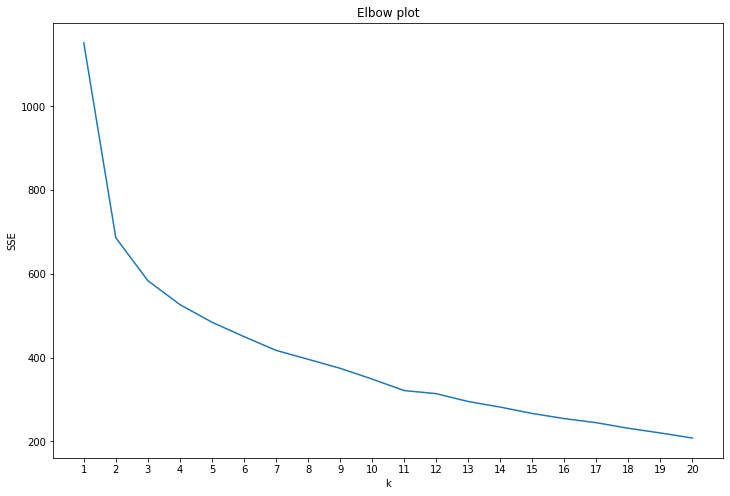

In [ ]:
# Elbow plot
plt.figure(figsize=(12,8))
plt.title('Elbow plot')
plt.ylabel('SSE')
plt.xlabel('k')
plt.xticks(k_range)
plt.plot(k_range, sse)

We will choose k = 4.

## **2.2. Clustering**

In [ ]:
k=4
kmeans = KMeans(n_clusters=k, n_init=20, random_state=1996).fit(X)

# Cluster labels
kmeans.labels_

array([2, 2, 2, 1, 2, 1, 0, 1, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 0, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       1, 3, 1, 1, 2, 1, 3, 3, 3, 0, 3, 3, 0, 1, 1, 3, 0, 1, 2, 1, 2, 1,
       1, 3, 3, 3, 3, 3, 2, 2, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3,
       0, 3, 2, 2, 2, 3, 1, 3, 3, 0, 3, 0, 3, 0, 0, 2, 2, 1, 3, 0, 3, 3,
       0, 3, 0, 3, 3, 1, 1, 3, 3, 3, 0, 0, 3, 0, 3, 3, 2, 2, 1, 1, 1, 1,
       3, 1, 3, 3, 3, 0, 0, 3, 3, 3, 2, 2], dtype=int32)

In [ ]:
# Add cluster labels
df_final = df.merge(df_venue_freq, how='left', on='Suburb')
df_final.insert(3, 'Cluster', kmeans.labels_)
df_final.head()

,Suburb,Latitude,Longitude,Cluster,Coffee shop,Dessert shop,Entertainment,Fitness/Sports,Food court/Restaurant,Market/Grocery,Recreational area,Shopping
0,"3000, Melbourne",-37.813000,144.960999,2,15,10,23,3,29,2,1,8
1,"3002, East Melbourne",-37.813000,144.983994,2,24,2,20,6,32,0,4,2
2,"3003, West Melbourne",-37.808998,144.947006,2,20,6,12,2,44,5,5,1
3,"3004, Melbourne",-37.841999,144.975998,1,16,0,3,2,13,2,2,1
4,"3008, Docklands",-37.818001,144.944000,2,20,5,9,3,39,4,6,4


We will map the clusters of suburbs.

In [ ]:
# Create a map of Melbourne
melb_map = folium.Map(location=[melb_lat, melb_lon], zoom_start=10)

# Set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, suburb, cluster in zip(df_final['Latitude'],
                                      df_final['Longitude'],
                                      df_final['Suburb'],
                                      df_final['Cluster']):
    label = folium.Popup(str(suburb) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(melb_map)
       
melb_map

The table below shows the center of each cluster, i.e., the average frequency of venue category.

In [ ]:
# Inverse transform cluster centers, as they were earlier standardized
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
df_clusters = pd.DataFrame(cluster_centers)
df_clusters.columns = df_clustering.columns
df_clusters.index.name = 'Cluster'
df_clusters

,Coffee shop,Dessert shop,Entertainment,Fitness/Sports,Food court/Restaurant,Market/Grocery,Recreational area,Shopping
Cluster,,,,,,,,
0,4.333333,1.500000,2.055556,1.888889,10.944444,4.166667,0.388889,3.333333
1,8.066667,2.133333,3.066667,1.766667,14.566667,4.000000,2.166667,0.533333
2,18.611111,5.277778,12.666667,3.277778,34.944444,5.388889,2.722222,1.888889
3,1.358974,0.525641,0.487179,0.833333,4.038462,1.717949,0.435897,0.474359


Based on the map and the cluster centers, we would describe each cluster as follows.
*   Cluster 2 (Blue): Very close to the city center, with more venues of most categories than any other cluster. Especially there are many coffee shops and food courts/restaurants.
*   Cluster 1 (Purple): Close to the city center, with decent quantities of coffee shops, food courts/restaurants and market/grocery.
*   Cluster 0 (Red): Far away from the city center, with decent quantities of coffee shops, food courts/restaurants, market/grocery and shopping centers.
*   Cluster 3 (Yellow): Far away from the city center, very few venues of each category.

The list of suburbs in each cluster is as follows.

***Cluster 0***

In [ ]:
df_final.loc[df_final['Cluster'] == 0, :].reset_index(drop=True)

,Suburb,Latitude,Longitude,Cluster,Coffee shop,Dessert shop,Entertainment,Fitness/Sports,Food court/Restaurant,Market/Grocery,Recreational area,Shopping
0,"3011, Seddon",-37.806000,144.891998,0,12,1,10,3,12,2,1,3
1,"3019, Braybrook",-37.785999,144.854996,0,0,1,1,5,4,5,1,1
2,"3037, Sydenham",-37.700001,144.766006,0,2,0,2,3,11,4,1,4
3,"3039, Moonee Ponds",-37.765999,144.919998,0,20,0,6,3,16,6,1,4
4,"3047, Broadmeadows",-37.683998,144.927002,0,1,1,2,0,9,2,0,5
5,"3108, Doncaster",-37.785000,145.125000,0,6,4,4,1,17,5,0,7
6,"3131, Nunawading",-37.818001,145.175995,0,3,0,0,1,10,3,0,3
7,"3136, Croydon",-37.793999,145.283997,0,2,0,1,3,2,3,0,2
8,"3140, Lilydale",-37.757999,145.354996,0,2,1,0,1,6,4,1,4
9,"3142, Toorak",-37.841999,145.014008,0,7,2,1,0,7,4,0,2


***Cluster 1***

In [ ]:
df_final.loc[df_final['Cluster'] == 1, :].reset_index(drop=True)

,Suburb,Latitude,Longitude,Cluster,Coffee shop,Dessert shop,Entertainment,Fitness/Sports,Food court/Restaurant,Market/Grocery,Recreational area,Shopping
0,"3004, Melbourne",-37.841999,144.975998,1,16,0,3,2,13,2,2,1
1,"3011, Footscray",-37.798000,144.895004,1,13,3,7,3,27,4,1,2
2,"3012, Kingsville",-37.808998,144.878998,1,7,1,0,1,6,3,3,1
3,"3012, West Footscray",-37.799000,144.871002,1,4,2,0,2,6,1,3,0
4,"3013, Yarraville",-37.817001,144.884003,1,15,4,2,2,17,6,3,2
5,"3016, Williamstown",-37.860001,144.891998,1,6,2,2,1,14,4,5,0
6,"3030, Werribee",-37.896999,144.656006,1,4,1,4,1,16,4,1,0
7,"3031, Kensington",-37.793999,144.925995,1,11,3,6,4,21,4,3,0
8,"3032, Ascot Vale",-37.777000,144.916000,1,4,2,5,2,7,4,1,0
9,"3032, Travancore",-37.783001,144.936996,1,6,2,4,5,16,7,3,0


***Cluster 2***

In [ ]:
df_final.loc[df_final['Cluster'] == 2, :].reset_index(drop=True)

,Suburb,Latitude,Longitude,Cluster,Coffee shop,Dessert shop,Entertainment,Fitness/Sports,Food court/Restaurant,Market/Grocery,Recreational area,Shopping
0,"3000, Melbourne",-37.813000,144.960999,2,15,10,23,3,29,2,1,8
1,"3002, East Melbourne",-37.813000,144.983994,2,24,2,20,6,32,0,4,2
2,"3003, West Melbourne",-37.808998,144.947006,2,20,6,12,2,44,5,5,1
3,"3008, Docklands",-37.818001,144.944000,2,20,5,9,3,39,4,6,4
4,"3032, Maribyrnong",-37.776001,144.889008,2,7,6,2,6,17,5,4,4
5,"3053, Carlton",-37.800999,144.966003,2,20,8,13,4,39,7,2,0
6,"3056, Brunswick",-37.766998,144.962006,2,20,8,15,5,31,11,1,5
7,"3066, Collingwood",-37.801998,144.987000,2,20,5,26,1,33,5,0,1
8,"3067, Abbotsford",-37.806000,145.001999,2,15,2,14,1,44,9,3,1
9,"3121, Richmond",-37.819000,145.001007,2,18,6,10,4,53,3,1,0


***Cluster 3***

In [ ]:
df_final.loc[df_final['Cluster'] == 3, :].reset_index(drop=True)

,Suburb,Latitude,Longitude,Cluster,Coffee shop,Dessert shop,Entertainment,Fitness/Sports,Food court/Restaurant,Market/Grocery,Recreational area,Shopping
0,"3012, Maidstone",-37.784000,144.873993,3,3,0,1,2,2,2,1,1
1,"3015, Newport",-37.842999,144.878006,3,6,1,1,0,3,2,1,0
2,"3015, South Kingsville",-37.831001,144.869995,3,0,1,0,1,3,1,1,0
3,"3015, Spotswood",-37.828999,144.880005,3,2,3,1,1,4,1,0,0
4,"3016, Williamstown North",-37.854000,144.871994,3,1,0,0,2,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
73,"3192, Cheltenham",-37.963001,145.065994,3,2,0,2,2,3,2,0,0
74,"3193, Beaumaris",-37.983002,145.039993,3,5,0,1,1,5,3,2,1
75,"3198, Seaford",-38.110001,145.136993,3,1,0,0,1,0,1,0,0
76,"3199, Frankston",-38.147999,145.141006,3,2,0,1,2,7,2,0,2
